In [1]:
import os, sys
import h5py
import numpy as np
import pandas as pd
import scipy
import math as m
import cmath
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from pprint import pprint
plt.switch_backend('TkAgg')


PROJECT_CWD = r"/workspace/"
sys.path.append(PROJECT_CWD)

from my_packages.neural_network.data_generators.mixed_array_generator import MixedArrayGenerator
from my_packages.neural_network.data_generators.iterator import DataIterator

from my_packages.neural_network.data_generators.mixed_array_generator import MixedArrayGenerator
from my_packages.neural_network.data_generators.iterator import DataIterator

# torch import 
import torch
from torch.utils.data import TensorDataset, DataLoader

print("cuda available: ", torch.cuda.is_available())
print("number of GPUs: ",torch.cuda.device_count())
print("I am currently using device number: ", torch.cuda.current_device())
print("the device object is: ", torch.cuda.device(0))
print("the device name is: ", torch.cuda.get_device_name(0))

cuda available:  True
number of GPUs:  1
I am currently using device number:  0
the device object is:  <torch.cuda.device object at 0x7fd0ba38fac0>
the device name is:  NVIDIA T600 Laptop GPU


In [2]:
# data parameters
resolution=(21,21)
field_res = (50,50)
xbounds = [-0.01, 0.01]
ybounds = [-0.01, 0.01]
dipole_height = 1e-3
substrate_thickness = 1.4e-2
substrate_epsilon_r = 4.4
dynamic_range = 2
probe_height = 0.6e-2
dipole_density_E = 0.1
dipole_density_H = 0.1


rmg = MixedArrayGenerator(
    resolution=resolution,
    xbounds=xbounds,
    ybounds=ybounds,
    dipole_height=dipole_height,
    substrate_thickness=substrate_thickness,
    substrate_epsilon_r=substrate_epsilon_r,
    probe_height=probe_height,
    dynamic_range=dynamic_range,
    f=[1e9],
    field_res=field_res,
    dipole_density_E=dipole_density_E,
    dipole_density_H=dipole_density_H
    )

data_iterator = DataIterator(rmg)


N = 10
N_test = 1

inputs, target = data_iterator.generate_N_data_samples(N)
train_and_valid_dataset = TensorDataset(torch.from_numpy(inputs).float(), torch.from_numpy(target).float())
print("train_dataset size: ", len(train_and_valid_dataset))


Generating data: 100%|██████████| 10/10 [00:07<00:00,  1.32samples/s]

train_dataset size:  10


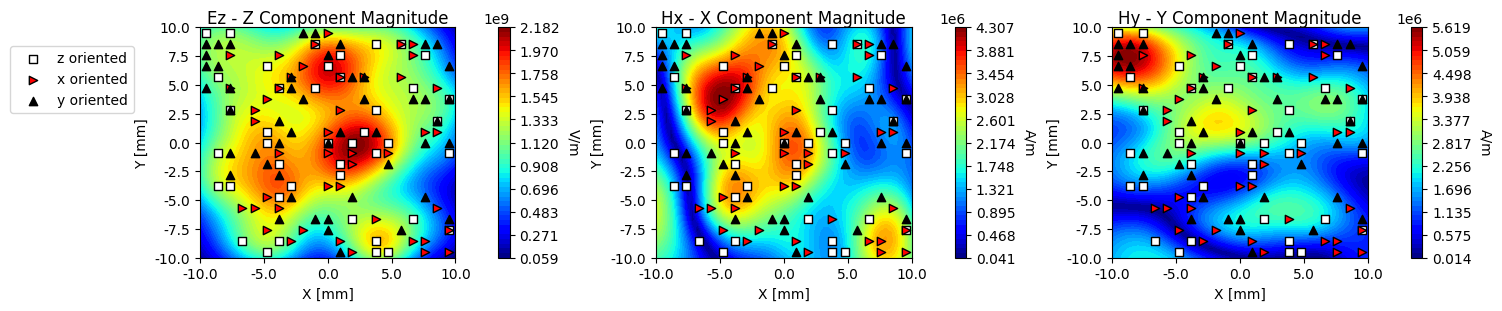

In [3]:
%matplotlib inline
d, l = next(iter(train_and_valid_dataset))

rmg.plot_labeled_data(d, l)

In [5]:
print(rmg.include_dipole_position_uncertainty)
darray = rmg._generate_random_array()

darray.r0
dfh = rmg._generate_fh()
dfh.dipole_array.r0

True


array([[-7.19497186e-03,  8.97396853e-03,  1.00000000e-03],
       [-6.55006218e-03, -7.25963484e-03,  1.00000000e-03],
       [-6.45855168e-03, -6.36214243e-03,  1.00000000e-03],
       [-6.54677667e-03, -4.69286829e-03,  1.00000000e-03],
       [-6.62741375e-03,  2.17861054e-03,  1.00000000e-03],
       [-6.97012597e-03,  5.75374674e-03,  1.00000000e-03],
       [-5.71624846e-03, -1.63508940e-03,  1.00000000e-03],
       [-5.50838788e-03,  1.38568954e-03,  1.00000000e-03],
       [-5.12235357e-03, -4.62682318e-03,  1.00000000e-03],
       [-4.48816942e-03,  9.84535002e-03,  1.00000000e-03],
       [-3.47535248e-03, -9.90079028e-03,  1.00000000e-03],
       [-4.02372752e-03,  9.62594909e-03,  1.00000000e-03],
       [-3.24834863e-03, -6.54958994e-03,  1.00000000e-03],
       [-3.20359025e-03,  6.63903498e-03,  1.00000000e-03],
       [-2.01964908e-03, -2.02117610e-03,  1.00000000e-03],
       [-7.16913748e-04, -4.51193352e-03,  1.00000000e-03],
       [ 2.33694390e-04, -6.83251952e-03

In [30]:
darray = rmg._generate_random_array()

def add_noise_to_dipole_array_xy(self: MixedArrayGenerator):
    darray = self._generate_random_array()
    xcell = np.diff(self.xbounds) / self.resolution[0]
    ycell = np.diff(self.ybounds) / self.resolution[1]

    # add a uniform random noise from -xcell/2 to xcell/2
    ndipoles = len(darray.dipoles)
    xnoise = np.random.uniform(-xcell/2, xcell/2, size=(ndipoles,))
    ynoise = np.random.uniform(-ycell/2, ycell/2, size=(ndipoles,))

    noise = np.stack((xnoise, ynoise, np.zeros_like(xnoise)), axis=1)

    new_r0 = darray.r0 + noise
    
    # update array position
    darray.r0 = new_r0
    return darray

rdarray = add_noise_to_dipole_array_xy(rmg)
rdarray.r0


array([[-9.61567492e-03, -8.99281329e-03,  1.00000000e-03],
       [-9.33931971e-03, -4.75301388e-03,  1.00000000e-03],
       [-9.43506774e-03,  7.12565448e-03,  1.00000000e-03],
       [-8.10024583e-03, -8.50241727e-03,  1.00000000e-03],
       [-8.53886341e-03, -4.24557308e-03,  1.00000000e-03],
       [-8.30036958e-03,  5.84012107e-03,  1.00000000e-03],
       [-7.91471725e-03, -3.58409813e-03,  1.00000000e-03],
       [-7.77950997e-03,  3.92548551e-03,  1.00000000e-03],
       [-6.72916367e-03,  1.14960692e-03,  1.00000000e-03],
       [-6.67603930e-03,  5.98915580e-03,  1.00000000e-03],
       [-5.59138449e-03, -5.35644410e-03,  1.00000000e-03],
       [-5.54207131e-03,  1.45134798e-03,  1.00000000e-03],
       [-2.70206667e-03, -8.94414414e-03,  1.00000000e-03],
       [-1.49728980e-03,  3.26821765e-03,  1.00000000e-03],
       [-1.14439152e-03,  3.15500113e-03,  1.00000000e-03],
       [-9.55010018e-04,  8.13655496e-03,  1.00000000e-03],
       [ 4.09602305e-04, -9.14971836e-03

In [29]:
darray.r0

array([[-0.0093518 , -0.00880992,  0.001     ],
       [-0.00976815, -0.00469788,  0.001     ],
       [-0.00959046,  0.00630262,  0.001     ],
       [-0.00844462, -0.00871554,  0.001     ],
       [-0.00858951, -0.00414095,  0.001     ],
       [-0.00822404,  0.00608652,  0.001     ],
       [-0.00739023, -0.00392102,  0.001     ],
       [-0.00744466,  0.00419403,  0.001     ],
       [-0.00636108,  0.00048268,  0.001     ],
       [-0.0066855 ,  0.00551157,  0.001     ],
       [-0.00566674, -0.00530812,  0.001     ],
       [-0.00605328,  0.00174524,  0.001     ],
       [-0.00238265, -0.00897738,  0.001     ],
       [-0.00175397,  0.00264263,  0.001     ],
       [-0.00054321,  0.00277344,  0.001     ],
       [-0.00133385,  0.00890835,  0.001     ],
       [-0.00015248, -0.00996676,  0.001     ],
       [-0.00019784,  0.00722225,  0.001     ],
       [ 0.00043047,  0.00849564,  0.001     ],
       [ 0.00049902, -0.00506327,  0.001     ],
       [ 0.00052376,  0.0011757 ,  0.001